# Lab 1: ROS Basics


At this point you have reviewed the Robot Operating System (ROS) and some of its main components,
this lab will help you to better understand each of them, and how they can be connected to
implement a simple task. The objective of this activity is to get familiarized with ROS by implementing
simple programs in a simulated environment, but also in a real platform such as the UCTRONICS Robot
Car Kit.<br><br>
ROS uses several levels of organization to encapsulate different pieces of software. The first level is
the workspace, which is a folder under which ROS has a predefined set of tools that are used to build
all the packages inside. A package is the next level of organization, it contains a collection of files
that implement a specific functionality. It is composed generally of a `launch` folder (containing launch
files), a `src` folder (containing source files such as cpp, py files), a `CMakeLists.txt` file (containing
a list of cmake rules for compilation), and a `package.xml` file (containing package information and
dependencies).
This lab will guide you through the process of creating a simple package, which will help you in next
steps to implement the desired functionality for the simulation and the car. This lab will last three weeks.
It is suggested that you finish part A and B in the first week, and part C and D for the second week, while the section E is left for the third week. You are free to progress as you wish, this is just an idea on how much you will have to spend on each section.



## Assignment

### A. ROS Publishers and Subscribers (Week1)
This section is aimed to serve as an introduction to publishers and subscribers in ROS. The instructions
under this section will be executed on Virtual Box using the `*.ova` image referred in lab 0.

1. Create a package by using the `catkin_create_pkg` script.

In [ ]:
# Go to the source folder in the workspace
$ cd ˜/catkin_ws/src
# Create a package with 2 dependencies std_msgs and rospy
$ catkin_create_pkg lab_1_pkg std_msgs rospy
# Got to the workspace root and make the newly created package
$ cd ˜/catkin_ws
˜/catkin_ws/ $ catkin_make
# In order to add the workspace to your ROS environment you need to run the setup.bash script
˜/catkin_ws/ $ source devel/setup.bash

A detailed explanation of package creation can be found [here](http://wiki.ros.org/ROS/Tutorials/CreatingPackage).

2. Go to the newly created package and create a basic folder structure.

In [ ]:
# Go to the source folder of the package
$ roscd lab_1_pkg
$ mkdir launch msg

3. Navigate to the `msg` folder and create a file called `CustomMessage.msg`. This file will define the
structure and fields of a complex data type that you will later use to transfer data between different
nodes.


In [ ]:
string text
uint32 ctr

4. You have created a message file, this file contains information about the fields that are part of any
message of this type. This information will be used by ROS toolchain to create a Python class that
can be imported by nodes anywhere in the workspace. In order to let the toolchain know about
this new message, you have to define that information somewhere. To do that, you need change the
`CMakeLists.txt` and, the `package.xml` files.

In [ ]:
# CMakeLists.txt
#...
find_package(catkin REQUIRED COMPONENTS
rospy
std_msgs
message_generation
)
#...
add_message_files(
FILES
CustomMessage.msg
)
#...
catkin_package(
# INCLUDE_DIRS include
# LIBRARIES lab_1_pkg
CATKIN_DEPENDS rospy std_msgs message_runtime
# DEPENDS system_lib
)
#...
generate_messages(
    DEPENDENCIES
    std_msgs
)

In [ ]:
<!-- package.xml -->
...
<build_depend>message_generation</build_depend>
...
<exec_depend>message_runtime</exec_depend>

5. Once the message is created and properly registered in the environment, you can proceed to make
the workspace and verify that ROS toolchain is recognizing properly the message that was added.
To do that, you need to navigate to `˜\catkin_ws\` and run the catkin_make command.


In [ ]:
˜/catkin_ws/ $ catkin_make
˜/catkin_ws/ $ source devel/setup.bash

6. Now you are ready to create a node. In order to do that, navigate to the `src` folder and create a python file called `lab1_tx.py`. To create a node, you will have to write the following code. Take a look at the code, regardless of the logic, nodes in ROS follow a similar code structure.

In [ ]:
#!/usr/bin/env python3
import rospy
from lab_1_pkg.msg import CustomMessage
from std_msgs.msg import String

def my_tx_node():
    # Create a publisher object with the custom type
    pub = rospy.Publisher('tx_msg', CustomMessage, queue_size=10)
    # Declare the node, and register it with a unique name
    rospy.init_node('my_tx_node', anonymous=True)
    # Define the execution rate object (10Hz)
    rate = rospy.Rate(10)
    
    '''
        This is the main node loop
    '''
    ctr = 0
    while not rospy.is_shutdown():
        # Create message object with a specific type
        msg = CustomMessage()
        # Populate custom message object
        msg.ctr = ctr
        ctr = ctr + 1
        msg.text = 'Message from node my_tx_node'
        # Log/trace information on console
        rospy.loginfo('[my_tx_node] Running')
        # Publish the data
        pub.publish(msg)
        # Sleep the necessary amount of time to keep a 10Hz execution rate
        rate.sleep()

if __name__ == '__main__':
    try:
        my_tx_node()
    except rospy.ROSInterruptException:
	    pass

7. One end of the example application has been created, so far you have a message type that can be
transmitted by the node implemented in the file `lab1_tx.py`. It is time to create the the receiver
node in a new file (`lab1_rx.py`). In ROS, a node can transmit and receive (publish and subscribe)
data, but in this example, we are creating two different nodes for each of these tasks. The receiver
will have to define a subscriber that will be getting all the data from the transmitting node. This
node will print in console the received information to verify that the application is working.

In [ ]:
#!/usr/bin/env python3
import rospy
from lab_1_pkg.msg import CustomMessage

def my_rx_callback(data):
    # data will contain the message information of type CustomMessage, we can access and print that data as follows.
    rospy.loginfo('Received ctr:{}, and text:{}'.format(data.ctr,data.text))
def my_rx_node():
    # Declare the node, and register it with a unique name
    rospy.init_node('my_rx_node', anonymous=True)
    # Define a subscriber that will catch the messages published by my_tx_node
    # Observe how the subscription has to match use some of the parameters defined for the publisher.
    rospy.Subscriber("tx_msg", CustomMessage, my_rx_callback)
    # This node doesn't have to run all the time, but whenever a message is received, therefore, we can leav it spinning (waiting to wake up whenever a message is available).
    rospy.spin()

if __name__ == '__main__':
    try:
        my_rx_node()
    except rospy.ROSInterruptException:
	    pass

A detailed tutorial on how to create a ROS publisher and subscriber using python can be found [here](http://wiki.ros.org/ROS/Tutorials/WritingPublisherSubscriber%28python%29).

8. At this point, all the files required for the application were created, the only missing part is to
execute each node and verify that the application is working as expected. To execute nodes, there
are at least 2 options: 1) run individually the created files and `roscore`, or 2) call everything from a
launch file and execute it using `roslaunch`. In order to call all the required executables/commands
individually, you will need to grant execution permission to the python files, and then open two more
terminals to run the executables as follows.

In [ ]:
# Terminal 1
~/catkin_ws/src/lab_1_pkg/src $ sudo chmod +x *.py
~/catkin_ws/src/lab_1_pkg/src $ roscore

In [ ]:
# Terminal 2
~/catkin_ws/src/lab_1_pkg/src $ ./lab1_tx.py

In [ ]:
# Terminal 3
~/catkin_ws/src/lab_1_pkg/src $ ./lab1_rx.py

9. For larger applications, it becomes inefficient to run every executable individually. To overcome this problem, ROS provides a tool called launch file, which allows to run all required entities from a single file. To do this, you will need to create a new file called `lab1.launch` under the `launch` directory. This file has an XML format, and lists all the required components for your application to run. You can find more details about the syntaxis of a launch file [here](http://wiki.ros.org/roslaunch/XML), for now you just need to understand that the launch file will help us execute all the nodes that you created at once, without having to call `roscore` in different terminals.

In [ ]:
<launch>
  <node pkg="lab_1_pkg" name="my_tx_node" type="lab1_tx.py" output="screen"/>
  <node pkg="lab_1_pkg" name="my_rx_node" type="lab1_rx.py" output="screen"/>
</launch>

10. Run the application and observe the results running with the two options provided. Verify the
correctness of the application by running the visualization tool `rqt_graph`.


In [ ]:
$ roslaunch lab1.launch



---

### B. Publishers and Subscribers Using Gazebo Simulation (Week1)
Now that you know how topics, publishers and subscribers work, it is time to use these concepts in
a way closer to what it would be in a real application. To do that, you will need to interact with the
Turtlebot 3 Gazebo simulation. The following instructions have to be implemented on the Virtual Machine
as the previous section.

1. Go to the launch file folder and create a new file called `lab_1_world.launch`.

In [ ]:
cd ~/catkin_ws/src/lab_1_pkg/launch


2. Copy and paste the following code to `lab_1_world.launch`.



In [ ]:
<launch>
  <arg name="model" default="burger"/>
  <arg name="x_pos" default="0.0"/>
  <arg name="y_pos" default="0.0"/>
  <arg name="z_pos" default="0.0"/>

  <include file="$(find gazebo_ros)/launch/empty_world.launch">
    <arg name="world_name" value="$(find turtlebot3_gazebo)/worlds/turtlebot3_stage_1.world"/>
    <arg name="paused" value="false"/>
    <arg name="use_sim_time" value="0.1"/>
    <arg name="gui" value="true"/>
    <arg name="headless" value="false"/>
    <arg name="debug" value="false"/>
  </include>  
    
  <param name="robot_description" command="$(find xacro)/xacro --inorder $(find turtlebot3_description)/urdf/turtlebot3_$(arg model).urdf.xacro" />

  <node name="spawn_urdf" pkg="gazebo_ros" type="spawn_model" args="-urdf -model turtlebot3_burger -x $(arg x_pos) -y $(arg y_pos) -z $(arg z_pos) -param robot_description" />
</launch>

3. Start the launch file.

In [ ]:
# Terminal 1
roslaunch lab_1_pkg lab_1_world.launch

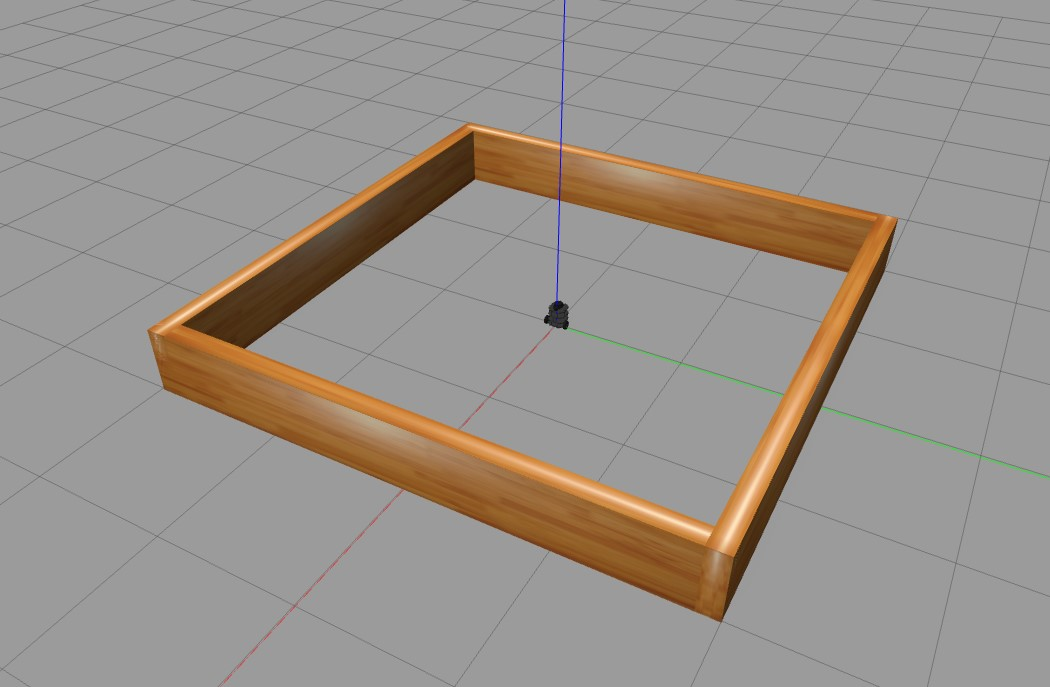

4. Check the available topics.

In [ ]:
# Terminal 2
rostopic list

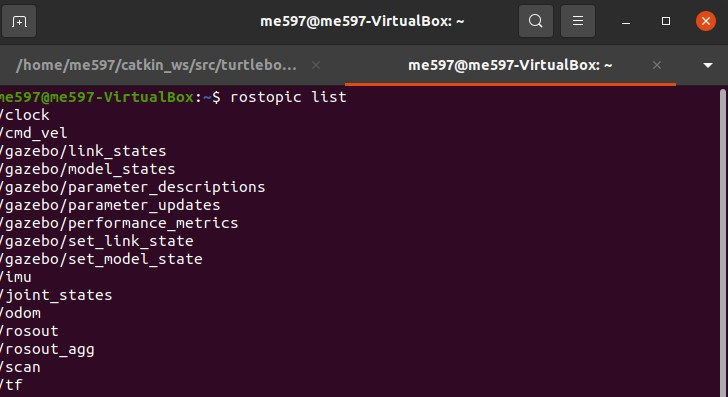

5. Move the robot. Use the following command to get the info of the topic that controls the turtlebot’s velocity.

In [ ]:
rostopic info /cmd_vel
rosmsg show Twist

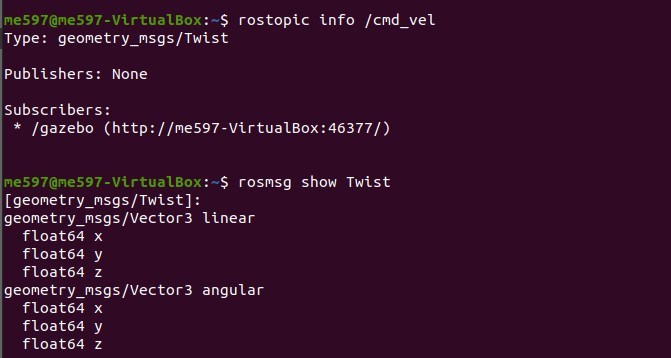

6. A simple way to move the robot is to use the keyboard.The following launch file will create
a note that reads the keyboard, writes the `Twist` message, and publishes the message to
`cmd_vel` topic.

In [ ]:
roslaunch turtlebot3_teleop turtlebot3_teleop_key.launch

7. Control the speed using a python script.

In [ ]:
#!/usr/bin/env python3
import rospy
from geometry_msgs.msg import Twist

def controller_node():
    # Create a publisher object with Twist
    pub = rospy.Publisher('cmd_vel', Twist, queue_size=1)
    # Declare the node, and register it with a unique name
    rospy.init_node('my_control_node', anonymous=True)
    # Define the execution rate object (10Hz)
    rate = rospy.Rate(10)

    '''
        This is the main node loop
    '''
    while not rospy.is_shutdown():
        # Create message object with a specific type
        vel_msg = Twist()

        # Populate custom message object
        vel_msg.linear.x = 1
        vel_msg.angular.z = 1
        # Log/trace information on console
        rospy.loginfo('[my_control_node] Running')
        # Publish the data
        pub.publish(vel_msg)
        # Sleep the necessary amount of time to keep a 10Hz execution rate
        rate.sleep()


if __name__ == '__main__':
    try:
        controller_node()
    except rospy.ROSInterruptException:
        pass

8. Reset the environment using ROS service

In [ ]:
rosservice call /gazebo/reset_simulation "{}"

9. Read the Lidar ranges using a subscriber.

The Lidar sensor on the turtlebot return 360 scan ranges. If we want to get the distance in front of the robot, we need to read `data.range[0]` in the callback function.


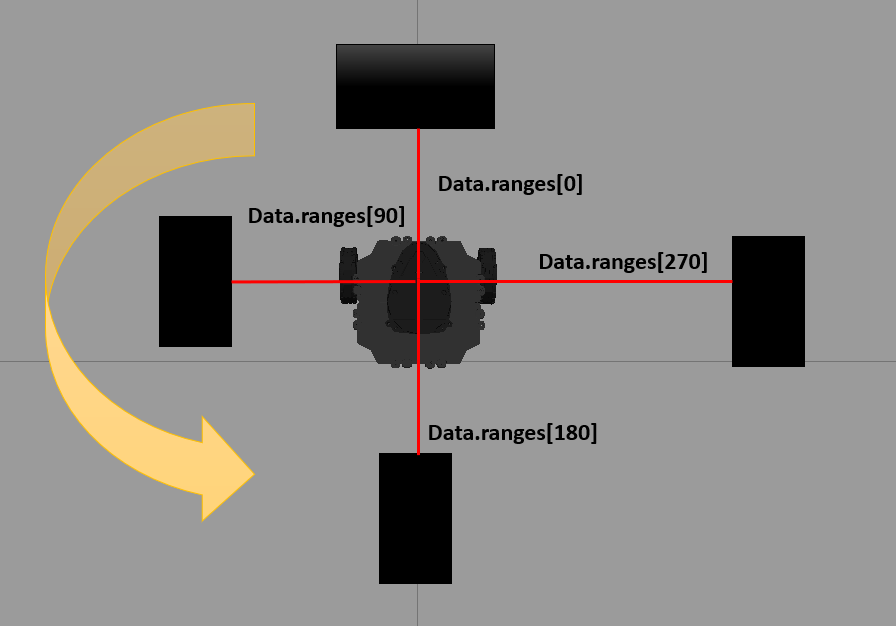

In [ ]:
#!/usr/bin/env python3
import rospy
from sensor_msgs.msg import LaserScan

def scan_callback(data):
    # data will contain the message information of type LaserScan, we can access and print that data as follows.
    rospy.loginfo('Received ctr:{}'.format(data.ranges[0]))

def scan_node():
    # Declare the node, and register it with a unique name
    rospy.init_node('scan_node', anonymous=True)
    # Define a subscriber that will catch the messages published by scan
    # Observe how the subscription has to match use some of the parameters defined for the publisher.
    rospy.Subscriber("/scan", LaserScan, scan_callback)
    # This node doesn't have to run all the time, but whenever a message is received, therefore, we can leave it spinning (waiting to wake up whenever a message is available).
    rospy.spin()


if __name__ == '__main__':
    try:
        scan_node()
    except rospy.ROSInterruptException:
        pass

10. Create a python script called `exercise_1.py` that can:
  *   Use a subscriber to read `dist = data.ranges[0]` from `/scan` to get the distance in front of the robot.
  *   Use a publisher to send a `vel_msg.linear.x = 0.5 * (dist - 1)` to /`cmd_vel` and make sure the robot can approach the wall and then stop.



---

### C. ROS Services (Week2)
1. Another way interact between nodes is through services, this ROS mechanism provides a way to
trigger the execution of different functions of a node(server) from a remote one (client). 
To understand
this concept, lets implement a server in the `lab1_rx.py` file, such that it prints the message
“service request received” every time the client in lab1_tx.py file requests a service called
`custom_service`. The first thing you have to do is to create a service file, such file contains the
request and the response parameters involved in the service execution.

In [ ]:
# CustomService.srv
# Request fields
uint32 arg_1
---
# Response fields
string out_1


More complicated services structures can be found [here](http://wiki.ros.org/srv)

2.  Before making the workspace, it is necessary to register the service. This will let ROS know what
classes to create to be able to use the service.

In [ ]:
<!-- package.xml -->
<!-- ... -->
<build_depend>message_generation</build_depend>
<!-- ... -->
<exec_depend>message_runtime</exec_depend>

In [ ]:
# CMakeLists.txt
#...
find_package(catkin REQUIRED COMPONENTS
rospy
std_msgs
message_generation
)
#...
add_service_files(
FILES
CustomService.srv
)
#...
catkin_package(
# INCLUDE_DIRS include
# LIBRARIES lab_1_pkg
CATKIN_DEPENDS rospy std_msgs message_runtime
# DEPENDS system_lib
)


For this lab, some of the lines above were already added for the message generation, therefore, you
don’t need to add them. However, it is important to mention that these lines are needed for proper
service generation.


3. Go the root of `catkin_ws` and make the workspace

In [ ]:
˜/catkin_ws/ $ catkin_make
˜/catkin_ws/ $ source devel/setup.bash

4. Append the following server code into the `lab1_rx.py`. This code will print in console as discussed in previous steps.

In [ ]:
#!/usr/bin/env python3
import rospy
from lab_1_pkg.msg import CustomMessage
from lab_1_pkg.srv import CustomService, CustomServiceResponse

def my_rx_callback(data):
    # data will contain the message information of type CustomMessage, we can access and print that data as follows.
    rospy.loginfo('Received ctr:{}, and text:{}'.format(data.ctr,data.text))
    
def my_rx_server_callback(req):
    rospy.loginfo('service request received arg_1:{}'.format(req.arg_1))
    return CustomServiceResponse('service executed')

def my_rx_node():
    # Declare the node, and register it with a unique name
    rospy.init_node('my_rx_node', anonymous=True)
    # Define a subscriber that will catch the messages published by my_tx_node
    # Observe how the subscription has to match use some of the parameters defined for the publisher.
    rospy.Subscriber("my_tx_node", CustomMessage, my_rx_callback)
    # Define the callback to be executed when the service CustomService is requested
    s = rospy.Service('custom_service', CustomService, my_rx_server_callback)
    # This node doesn't have to run all the time, but whenever a message is received, therefore, we can leav it spinning (waiting to wake up whenever a message is available).
    rospy.spin()

if __name__ == '__main__':
    try:
        my_rx_node()
    except rospy.ROSInterruptException:
	    pass

5. Append the following client code into the lab1_tx.py. This logic will request the execution of
the code that will print in terminal the message “service request received”

In [ ]:
#!/usr/bin/env python3
import rospy
from lab_1_pkg.msg import CustomMessage
from lab_1_pkg.srv import CustomService, CustomServiceRequest, CustomServiceResponse

def call_custom_service(arg_srv):
    rospy.wait_for_service('custom_service')
    try:
        cust_srv = rospy.ServiceProxy('custom_service', CustomService)
        srv_resp = cust_srv(arg_srv)
        return srv_resp.out_1
    except rospy.ServiceException as e:
        pass

def my_tx_node():
    # Create a publisher object with the custom type
    pub = rospy.Publisher('tx_msg', String, queue_size=10)
    # Declare the node, and register it with a unique name
    rospy.init_node('my_tx_node', anonymous=True)
    # Define the execution rate object (10Hz)
    rate = rospy.Rate(10)
    
    '''
        This is the main node loop
    '''
    ctr = 0
    while not rospy.is_shutdown():
        # Create message object with a specific type
        msg = CustomMessage()
        # Populate custom message object
        msg.ctr = ctr
        ctr = ctr + 1
        msg.text = 'Message from node my_tx_node'
        # Log/trace information on console
        rospy.loginfo('[my_tx_node] Running')
        # Publish the data
        pub.publish(msg)
        if (ctr%10)==0:
            call_custom_service(ctr)
        # Sleep the necessary amount of time to keep a 10Hz execution rate
        rate.sleep()

if __name__ == '__main__':
    try:
        my_node()
    except rospy.ROSInterruptException:
	    pass

A ROS tutorial on services can be found in the following [link](http://wiki.ros.org/ROS/Tutorials/WritingServiceClient%28python%29)

---

### D. Services Using Gazebo Simulation(Week2)
In this section, you will practice what you learned from I-C using a Turtlebot in Gazebo simulation environment 
1. Change robot’s position using ROS service. Create a file called `position_service.py`. Copy and paste following code.

In [ ]:
#!/usr/bin/env python3
import rospy
from gazebo_msgs.srv import SpawnModel, DeleteModel, SetModelState
from gazebo_msgs.msg import ModelState


def position_node():
    # Create a publisher object with Twist
    pub_model = rospy.Publisher('gazebo/set_model_state', ModelState, queue_size=1)
    # Declare the node, and register it with a unique name
    rospy.init_node('model_service_node', anonymous=True)
    # Define the execution rate object (10Hz)
    rate = rospy.Rate(10)

    '''
        This is the main node loop
    '''

    while not rospy.is_shutdown():
        # Create message object with a specific type
        state_msg = ModelState()
        state_msg.model_name = 'turtlebot3_burger'
        rospy.wait_for_service('/gazebo/set_model_state')

        state_msg.pose.position.x = 1
        state_msg.pose.position.y = 1
        try:
            set_state = rospy.ServiceProxy('/gazebo/set_model_state', SetModelState)
            resp = set_state(state_msg)

        except rospy.ServiceException:
            print("Service call failed: ")

 
        # Sleep the necessary amount of time to keep a 10Hz execution rate
        rate.sleep()

if __name__ == '__main__':
    try:
        position_node()
    except rospy.ROSInterruptException:
        pass

2. Use the `position_service.py` as a template. Create a script called `exercise_2.py` that can change the robot’s position from (0, 0) to (1, 0) with a step size of 0.05 m.

---

### E. ROS Using UCTRONICS Car (Week3)
For the practical implementation you will have to create a node capable of moving the car and reading
the ultrasonic sensor. To do this you will need to implement a ROS architecture as shown in the diagram below.
You will find that the the image in the RPi already contains a workspace (`aut_sys_ws`) and a package with some of the drivers interact with the sensors and actuators of the car. The ROS architecture below contains the actual names of the topics and nodes that you will need for this section. The orange node is the one that you will have to create. In  this same diagram, the orange node has to publish data to the `/motors` topic, and catch data from the `/distance `topic. This implementation will be the basis of future labs involving the car.

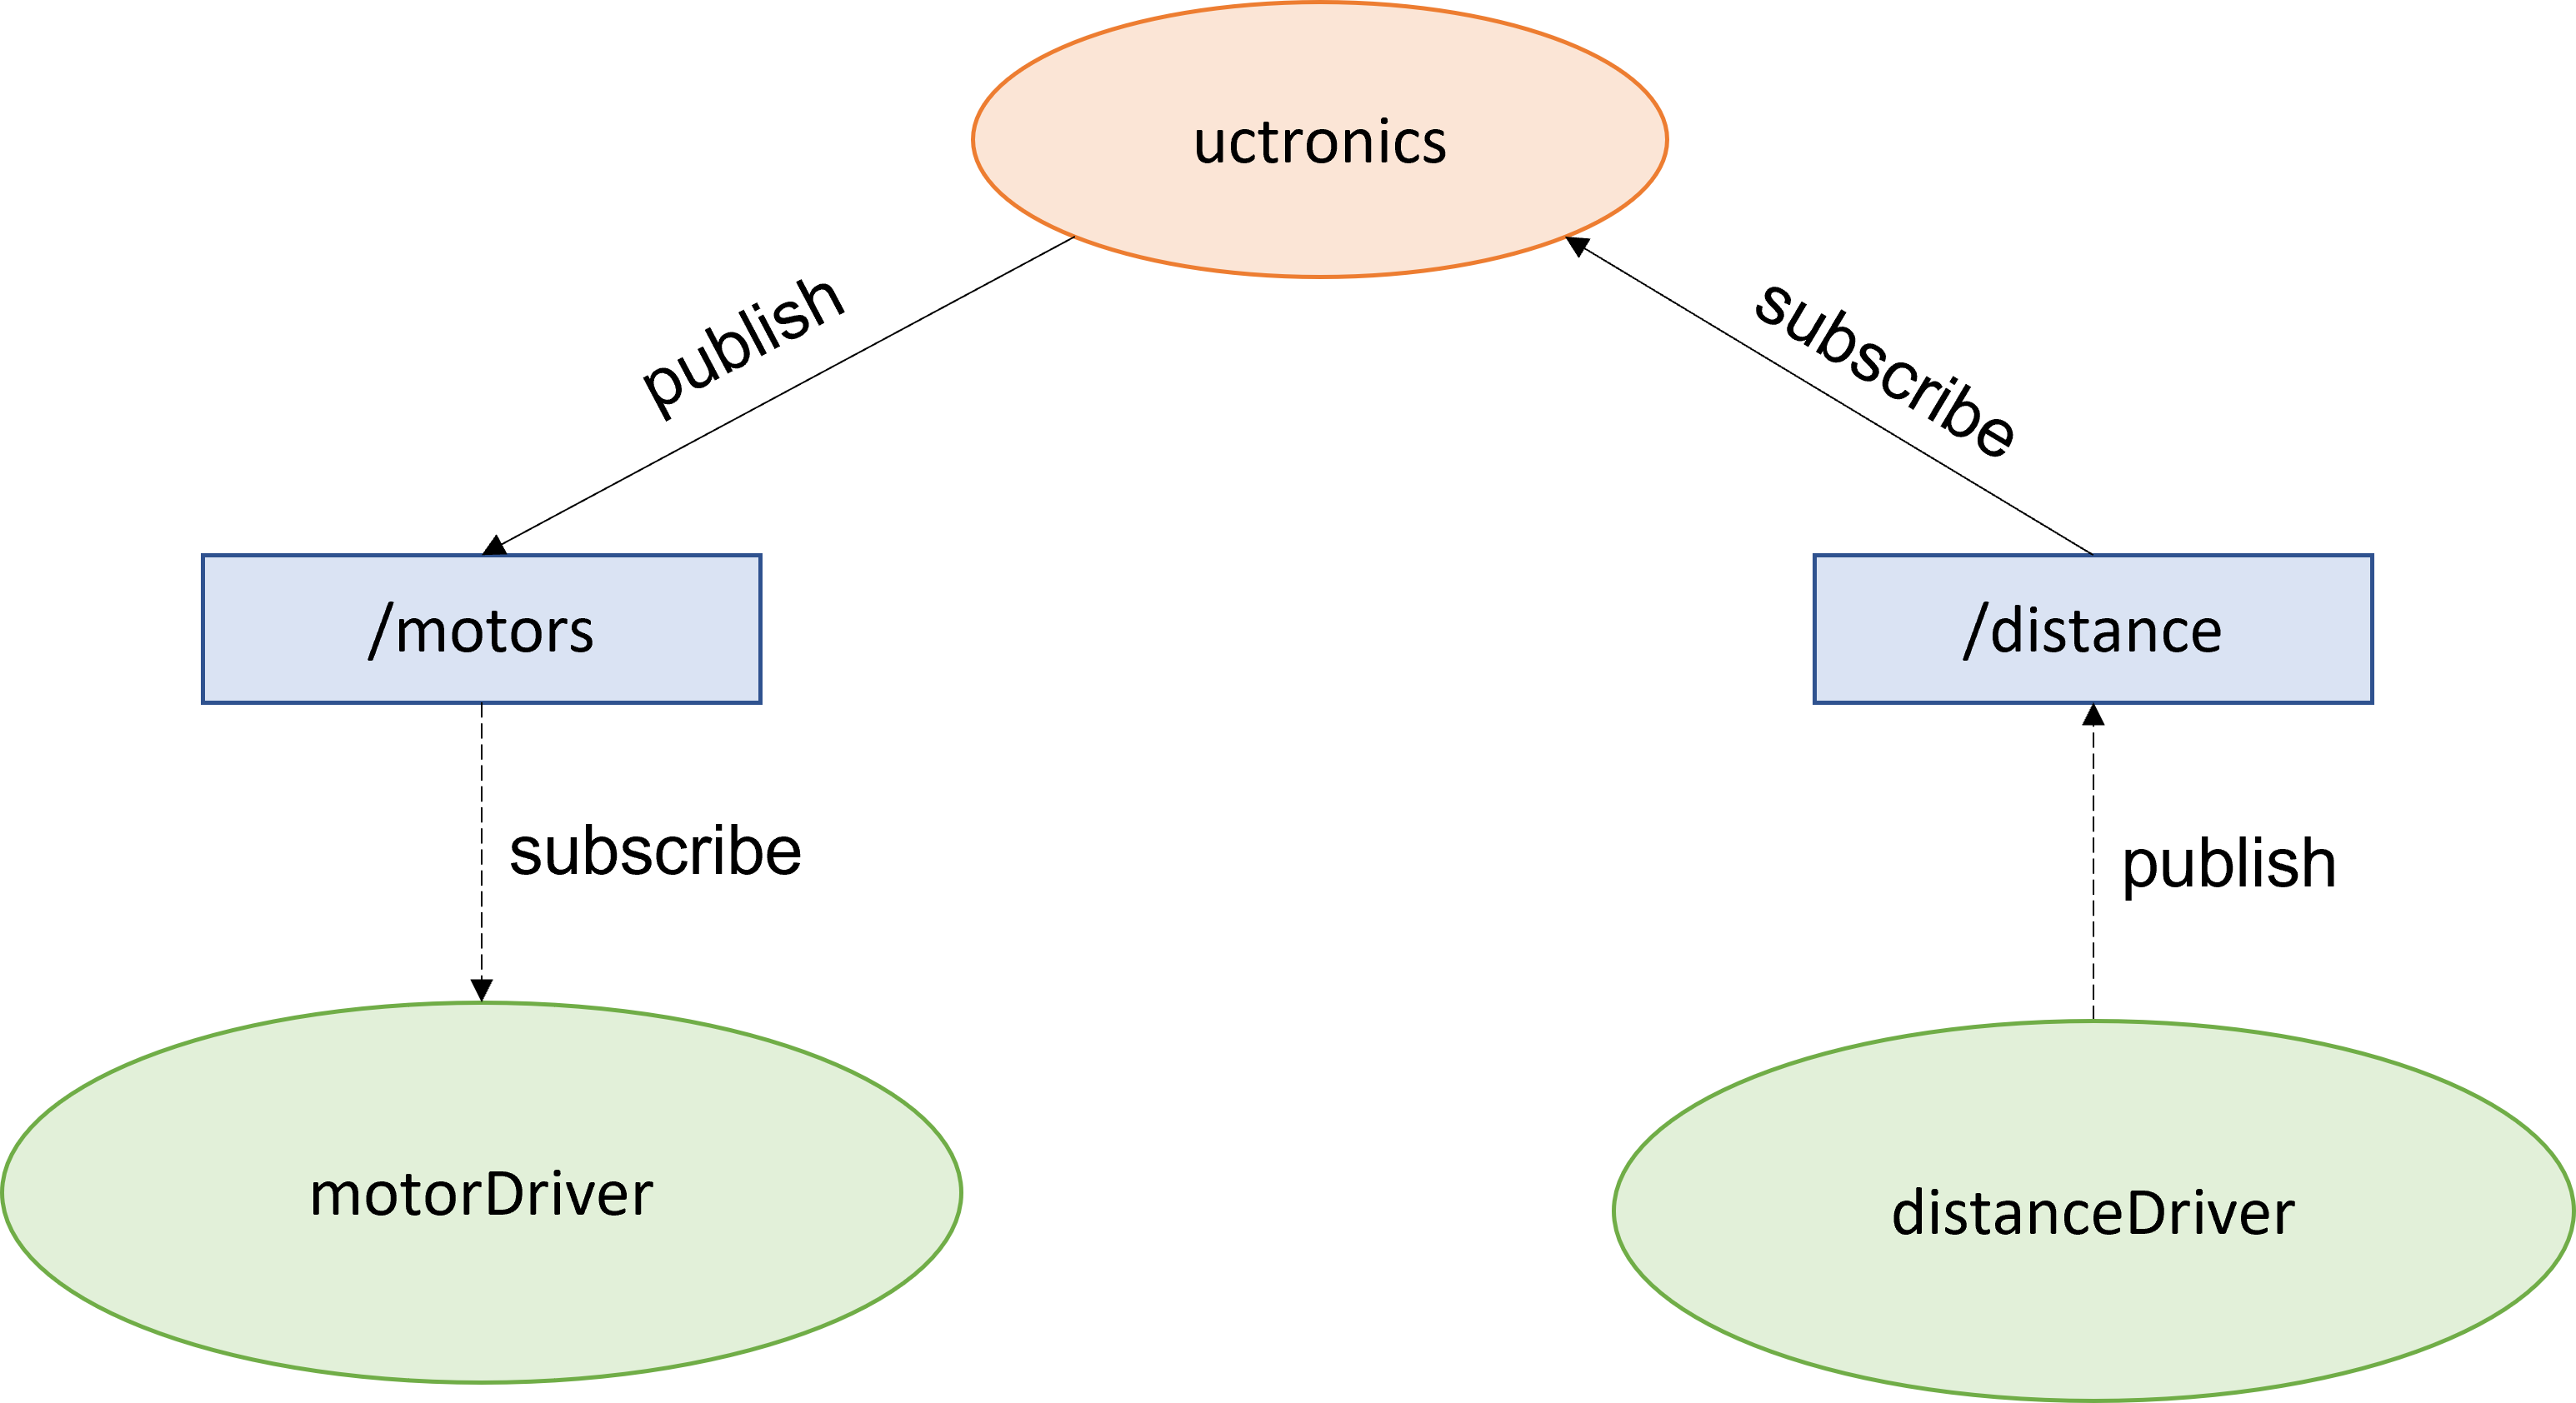

1. Under the package `aut_sys` create a file called `uctronics.py` This file must contain a publisher and a subscriber similar to the ones created in Sec.I-A, but in this case, the message type, and the topic names are different. Remember that message types have to be imported from the package
owning the message. In this case, the package has already been created (`aut_sys`), explore the files in the msg folder and identify the message types that have to be used.

2. The `/distance` topic retrieves a distance measured from the ultrasonic sensor as a floating point value in meters, you will have to implement the logic to print this value and move the car in a straight line for 2 seconds.

3. Once the logic is ready, you will need to execute the application to verify it is working. To do that, you need to include the newly created node into the existing `run_car.launch` file.

4. Verify the correctness of your system architecture by using the visualization command `rqt_graph`.

## DELIVERABLES

1. Sections A through D will be delivered individually, while section E will be reviewed by teams.
2. You will need to deliver the code for each of the packages that you created.It is important that you **share the whole ROS package**, otherwise we won’t be able to run your code which will impact your grade for this lab.

3. For the section using the car, besides the code that you will have to deliver, you need to show that your car is working as requested.


## RUBRIC

*   20 pts - Implementing the packages as requested in sections A through E.
*   25 pts - Publishers and Subscribers Using Gazebo Simulation .
  *   20 pts - `exercise_1.py` works as requested.
  *   5  pts - Properly commented code.
*   25 pts - Services Using Gazebo Simulation  .
  *   20 pts - `exercise_2.py` works as requested.
  *   5 pts  - Properly commented code.
*   30 pts - ROS Using UCTRONICS Car .
  * 15 pts - `uctronics.py` and  `run_car.launch` work as requested.
  * 10 pts - Car behaves as requested.
  * 5 pts - Properly commented code.